# **IMPORTADO DE MÓDULOS/FUNCTIONS**

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

2024-05-30 17:42:35.701033: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 17:42:35.724868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 17:42:36.114310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
source = 'Co60'
path = '/home/josea/PracticaTimingDigital/pulso_' + source + '_filt_norm.npz'

data = np.load(path)
pulsos_practica_master = data['data']

In [4]:
from functions import gauss, gauss_fit, create_and_delay_pulse_pair, move_to_reference, get_mean_pulse_from_set, pulso_escalon, create_position
from Models import model_definition_convolutional

# **INTERPOLACION**

In [5]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28,  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55,  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82,  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)

interp_func_practica = interp1d(tiempo, pulsos_practica_master,  kind='cubic', axis=1)
new_pulsos_practica = interp_func_practica(tiempo_new)

#---------------------------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_pulsos_practica[:,:,1] = np.roll(new_pulsos_practica[:,:,1], align_steps)
new_pulsos_practica[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


#----------------------------------------------------- Print important information -----------------------------------
print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [6]:
#------------------------------------- Define number of training examples --------------------------------
Ntrain_practicas = int(0.8*new_pulsos_practica.shape[0])
Ncasos_sim = 100
Nc = 2

#------------------------------------- Basic definitions for sim pulses -----------------------------
t = np.linspace(0,Nt,Nt_new)
#t0 = 65 + np.random.randint(5, size=Ncasos) 
#t0 = 600 + np.random.randint(100, size = Ncasos)
t0 = 78 + np.random.randint(5, size = Ncasos_sim) 

# **TRAINING IN COINCIDENCE**

In [7]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 3
tau_drop_dec0 = 150
Photon_yield = 100
center_window_dec0 = 0.3
rise_window_dec0 = 0.3

#--------------------------------- Detector 1 definitions -------------------------
tau_rise_dec1 = 3
tau_drop_dec1 = 150
Photon_yield = 100
center_window_dec1 = 0.3
rise_window_dec1 = 0.3

In [8]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  
  centro = t0[i]
  #PULSO = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A=0.7)
  PULSO = pulso_escalon(t, centro, A= 0.7)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO
  INPUT_dec1[i,:] = PULSO


#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)

In [10]:
#------------------------------------- Train-Validation set --------------------------------
train_data = new_pulsos_practica[:Ntrain_practicas]
validation_data = new_pulsos_practica[Ntrain_practicas:]

#------------------------------------- Define cropping limits ------------------------------
t_shift = 8
start = 50*EXTRASAMPLING
stop = 80*EXTRASAMPLING

#------------------------------------- Create other positions for training / validation  --------------------------------

Train_data_02 = create_position(train_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
Train_data_20 = create_position(train_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)

validation_data_02 = create_position(validation_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
validation_data_20 = create_position(validation_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)


#------------------------------------- Reference time difference --------------------------------
REF = np.zeros(3*train_data.shape[0])
REF[:train_data.shape[0]] = 0.0
REF[train_data.shape[0]:2*train_data.shape[0]] = -t_shift*new_time_step
REF[2*train_data.shape[0]:3*train_data.shape[0]] = t_shift*new_time_step
REF_train = np.concatenate((REF_dec0, REF), axis = 0)



#------------------------------------- Concatenate training/validation sets --------------------------------
trainX = np.concatenate((INPUT_dec0[:,start:stop,:], train_data[:,start:stop,:], Train_data_02[:,start:stop,:], Train_data_20[:,start:stop,:]), axis = 0). swapaxes(1,2) #Swap the axis so they are the right shape for the NN
validationX = np.concatenate((validation_data[:,start:stop,:], validation_data_02[:,start:stop,:], validation_data_20[:,start:stop,:]), axis = 0). swapaxes(1,2) #Swap the axis so they are the right shape for the NN

In [12]:
#------------------------------------- Define neural network model --------------------------------
model = model_definition_convolutional(int(stop-start))

#opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer='AdamW',loss='MSE')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 2, 240, 4)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 120, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 120, 4)      │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,017 (7.88 KB)

 Trainable params: 2,017 (7.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(trainX, REF_train, epochs = 100, batch_size = 512)

Epoch 1/100


I0000 00:00:1717083841.378050 2312438 service.cc:145] XLA service 0x7835d8017430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717083841.378076 2312438 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-05-30 17:44:01.393106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-30 17:44:01.450007: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0282

I0000 00:00:1717083842.445983 2312438 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0281
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0257 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0241 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0090 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0070 
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069 
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0068 
E

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step

CENTROID(ns) = -0.196  FWHM(ns) = 0.034  std(ns) = 0.014
CENTROID(ns) = -0.010  FWHM(ns) = 0.170  std(ns) = 0.072
CENTROID(ns) = 0.195  FWHM(ns) = 0.033  std(ns) = 0.014


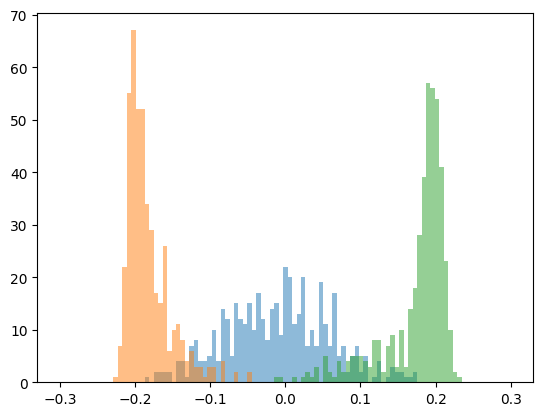

In [14]:
#------------------------------------------- Make prediction ----------------------------------------------
TOF = model.predict(validationX[:validation_data.shape[0],:,:])
TOF_02 = model.predict(validationX[validation_data.shape[0]:int(2*validation_data.shape[0]),:,:])
TOF_20 = model.predict(validationX[2*validation_data.shape[0]:3*validation_data.shape[0],:,:])

#------------------------------------------- Histogram and gaussian fit -----------------------------------
nbins = 101
histogN_V82, binsN, patchesN  = plt.hist(TOF, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOF_02, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(TOF_20, bins = nbins, range=[-0.3,0.3], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_V82)

FWHMN = 2.35482 * sigmaN
FWHMN_02 = 2.35482 * sigmaN_02
FWHMN_20 = 2.35482 * sigmaN_20


print('')
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **SINGLES TRAINING**

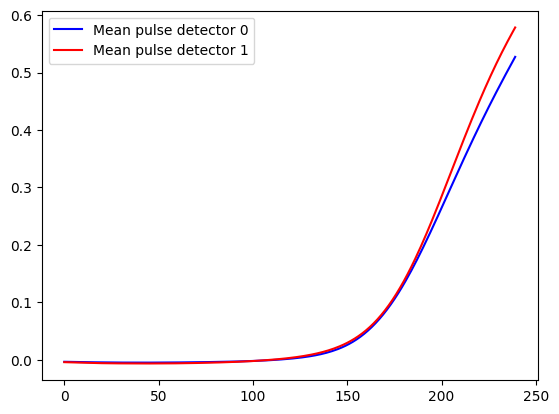

In [15]:
mean_pulse_dec0 = get_mean_pulse_from_set(new_pulsos_practica, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_pulsos_practica, channel = 1)

#-------------------------------------- Plot cropped mean pulses -----------------------------
plt.plot(mean_pulse_dec0[start:stop], 'b-', label = 'Mean pulse detector 0')
plt.plot(mean_pulse_dec1[start:stop], 'r-', label = 'Mean pulse detector 1')
plt.legend()

In [16]:
#------------------------------ Create simulated pulses ---------------------------------
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new))
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new))

for i in range(Ncasos_sim):
  
  centro = t0[i]
  #PULSO = pulso(t, centro,  tau_rise = tau_rise_dec0)
  #PULSO = pulso(t, centro, tau_rise = tau_rise_dec1)
  PULSO = pulso_escalon(t, centro, A=0.7)
  PULSO = pulso_escalon(t, centro, A= 0.7)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec0, rise_window = rise_window_dec0, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0, NOISE = False)
  #PULSO = pulso_sigmoid(tiempo_new, centro, A = Photon_yield, center_window = center_window_dec1, rise_window = rise_window_dec1, tau_rise = tau_rise_dec1, tau_drop = tau_drop_dec1, NOISE = False)
  INPUT_dec0[i,:] = PULSO
  INPUT_dec1[i,:] = PULSO


#-------------------------------- Delay simulated pulses --------------------------------------------
INPUT_dec0, REF_dec0 = create_and_delay_pulse_pair(INPUT_dec0, new_time_step, delay_steps = 32, NOISE = True)
INPUT_dec1, REF_dec1 = create_and_delay_pulse_pair(INPUT_dec1, new_time_step, delay_steps = 32, NOISE = True)


In [17]:
#---------------------------------------------- Move to reference pulse --------------------------------
#delays_train_dec0 , moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[:Ntrain_practicas,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
#delays_train_dec1 , moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[:Ntrain_practicas,:,:], start = start, stop = stop, max_delay = 240, channel = 1)


#---------------------------------------------- Delay real pulses --------------------------------
trainX_real_dec0, REF_real_train_dec0 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practicas,:,0], new_time_step, delay_steps = 32, NOISE = True)
trainX_real_dec1, REF_real_train_dec1 = create_and_delay_pulse_pair(new_pulsos_practica[:Ntrain_practicas,:,1], new_time_step, delay_steps = 32, NOISE = True)
#trainX_real_dec0, REF_real_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = 20, NOISE = True)
#trainX_real_dec1, REF_real_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = 20, NOISE = True)

In [18]:
#---------------------------------------------- Create training set --------------------------------
trainX_dec0 = np.concatenate((INPUT_dec0, trainX_real_dec0), axis = 0)
trainX_dec1 = np.concatenate((INPUT_dec1, trainX_real_dec1), axis = 0)

REF_train_dec0 = np.concatenate((REF_dec0, REF_real_train_dec0), axis = 0)
REF_train_dec1 = np.concatenate((REF_dec1, REF_real_train_dec1), axis = 0)

In [19]:
#-------------------------------- Swap axis to be compatible with the NN -------------------------------
trainX_dec0 = trainX_dec0[:,start:stop,:].swapaxes(1,2)
trainX_dec1 = trainX_dec1[:,start:stop,:].swapaxes(1,2)

## **FULL TOF**

In [20]:
#------------------------------------- Create reference pulses --------------------------------
REFERENCE_PULSE_dec0 = np.tile(mean_pulse_dec0[start:stop], (new_pulsos_practica[Ntrain_practicas:,:,:].shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(mean_pulse_dec1[start:stop], (new_pulsos_practica[Ntrain_practicas:,:,:].shape[0],2,1)).swapaxes(1,2)


#--------------------------------------- Move pulses to a reference one -------------------------------------------------
#delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, new_pulsos_practica[Ntrain_practicas:,:,:], start = start, stop = stop, max_delay = 240, channel = 0)
#delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, new_pulsos_practica[Ntrain_practicas:,:,:], start = start, stop = stop, max_delay = 240, channel = 1)


#validation_data = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
validation_data = new_pulsos_practica[Ntrain_practicas:,start:stop,:]

validation_data_02 = create_position(validation_data, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = True)
validation_data_20 = create_position(validation_data, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = True)  

#--------------------------------------- Create test set -------------------------------------------------
test_dec0_00 = np.stack((REFERENCE_PULSE_dec0[:,:,0], validation_data[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_00 = np.stack((REFERENCE_PULSE_dec1[:,:,0], validation_data[:,:,1]), axis = 2).swapaxes(1,2)
test_dec0_02 = np.stack((REFERENCE_PULSE_dec0[:,:,0], validation_data_02[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_02 = np.stack((REFERENCE_PULSE_dec1[:,:,0], validation_data_02[:,:,1]), axis = 2).swapaxes(1,2)
test_dec0_20 = np.stack((REFERENCE_PULSE_dec0[:,:,0], validation_data_20[:,:,0]), axis = 2).swapaxes(1,2)
test_dec1_20 = np.stack((REFERENCE_PULSE_dec1[:,:,0], validation_data_20[:,:,1]), axis = 2).swapaxes(1,2)

In [31]:
epochs = 10
num_semillas = 10

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_00_list = []
TOFN_02_list = []
TOFN_20_list = []

for i in range(num_semillas):
  
  model_dec0 = model_definition_convolutional(int(stop-start))
  model_dec1 = model_definition_convolutional(int(stop-start))

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 5e-3)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 5e-3)

  model_dec0.compile(optimizer = opt_dec0,loss = 'MSE')
  model_dec1.compile(optimizer = opt_dec1,loss = 'MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_00_epoch = []
  TOFN_02_epoch = []
  TOFN_20_epoch = []

  for epoch in range(epochs):
     
     history_dec0 = model_dec0.fit(trainX_dec0, REF_train_dec0, epochs = 150, batch_size = 64, verbose = 0)
     history_dec1 = model_dec1.fit(trainX_dec1, REF_train_dec1, epochs = 150, batch_size = 64, verbose = 0)
     
     loss_dec0.append(history_dec0.history['loss'][-1])
     loss_dec1.append(history_dec1.history['loss'][-1])

     
     TOFN_dec0_REF_00 = model_dec0.predict(test_dec0_00)
     TOFN_dec1_REF_00 = model_dec1.predict(test_dec1_00)
     TOFN_dec0_REF_02 = model_dec0.predict(test_dec0_02)
     TOFN_dec1_REF_02 = model_dec1.predict(test_dec1_02)
     TOFN_dec0_REF_20 = model_dec0.predict(test_dec0_20)
     TOFN_dec1_REF_20 = model_dec1.predict(test_dec1_20)

     
     #TOFN_00 = (np.squeeze(TOFN_dec0_REF_00) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_00) - new_time_step*delays_test_dec1)
     #TOFN_02 = (np.squeeze(TOFN_dec0_REF_02) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_02) - new_time_step*delays_test_dec1)
     #TOFN_20 = (np.squeeze(TOFN_dec0_REF_20) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_20) - new_time_step*delays_test_dec1)
     
     
     TOFN_00 = TOFN_dec0_REF_00 - TOFN_dec1_REF_00
     TOFN_02 = TOFN_dec0_REF_02 - TOFN_dec1_REF_02
     TOFN_20 = TOFN_dec0_REF_20 - TOFN_dec1_REF_20
     
     
     TOFN_00_epoch.append(TOFN_00)
     TOFN_02_epoch.append(TOFN_02)
     TOFN_20_epoch.append(TOFN_20)
 
     centroid_02 = -1*np.mean(TOFN_02) + np.mean(TOFN_00)
     centroid_20 = -1*np.mean(TOFN_20) + np.mean(TOFN_00)
     mean_error_centroid = (abs(centroid_02 + 0.2) + abs(centroid_20 - 0.2)) / 2 
     mean_std = (np.std(TOFN_00) +  np.std(TOFN_02) + np.std(TOFN_20)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_00_list.append(TOFN_00_epoch)
  TOFN_02_list.append(TOFN_02_epoch)
  TOFN_20_list.append(TOFN_20_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_00_array = np.array(TOFN_00_list, dtype = 'object')
TOFN_02_array = np.array(TOFN_02_list, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_list, dtype = 'object')

(array([3]), array([20])) 0.08887773038849131


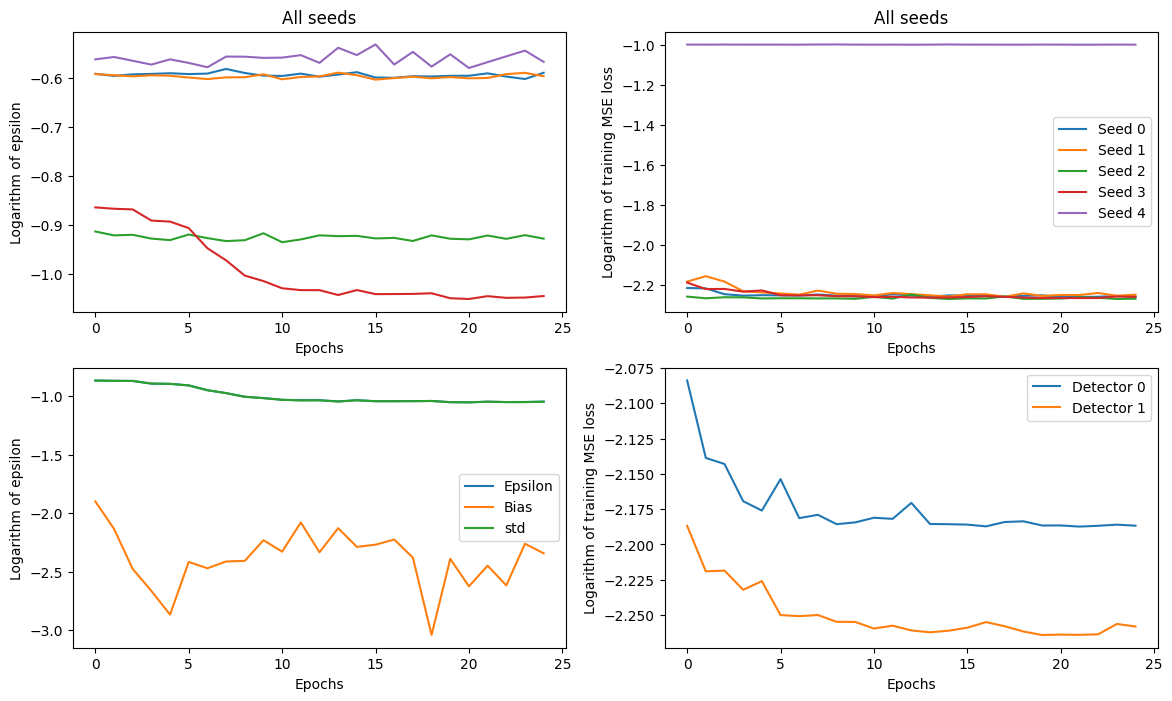

In [ ]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 3
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(bias[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training MSE loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training MSE loss')
plt.xlabel('Epochs')

plt.legend()


02: CENTROID(ns) = -0.192  FWHM(ns) = 0.216  std(ns) = 0.092
00: CENTROID(ns) = 0.004  FWHM(ns) = 0.210  std(ns) = 0.089
20: CENTROID(ns) = 0.205  FWHM(ns) = 0.212  std(ns) = 0.090


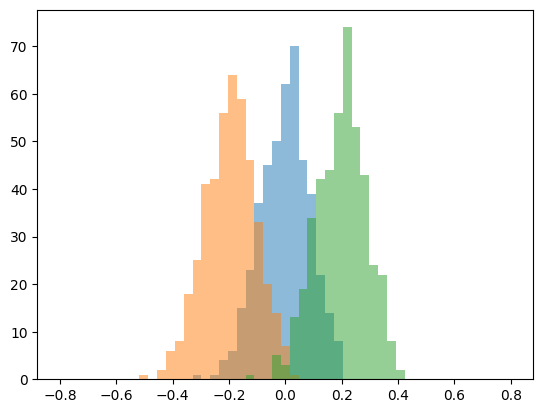

In [30]:
epoch = 20
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_00_array[index,epoch,:]) + np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_00, sigmaN_00 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_02_array[index,epoch,:]) + np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_02, sigmaN_02 = gauss_fit(cbinsN, histogN_V82)

histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_20_array[index,epoch,:]) + np.mean(TOFN_00_array[index,epoch,:]), bins = nbins, range = [-0.8,0.8], alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_20, sigmaN_20 = gauss_fit(cbinsN, histogN_V82)

FWHMN_00 = 2.35482 * sigmaN_00
FWHMN_02 = 2.35482 * sigmaN_02
FWHMN_20 = 2.35482 * sigmaN_20



print('')
print("02: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_02, FWHMN_02, sigmaN_02))
print("00: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_00, FWHMN_00, sigmaN_00))
print("20: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_20, FWHMN_20, sigmaN_20))

# **ENSEMBLE MODEL**

In [ ]:
#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_00 = np.average(np.squeeze(TOFN_00_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_02 = np.average(np.squeeze(TOFN_02_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)
weighted_mean_20 = np.average(np.squeeze(TOFN_20_array[:,epoch,:]), weights = (1/bias[:,epoch]), axis = 0)


Weighted mean:
V82: CENTROID(ns) = 0.198  FWHM(ns) = 0.304  std(ns) = 0.129
V55: CENTROID(ns) = -0.002  FWHM(ns) = 0.304  std(ns) = 0.129
V28: CENTROID(ns) = -0.197  FWHM(ns) = 0.312  std(ns) = 0.133


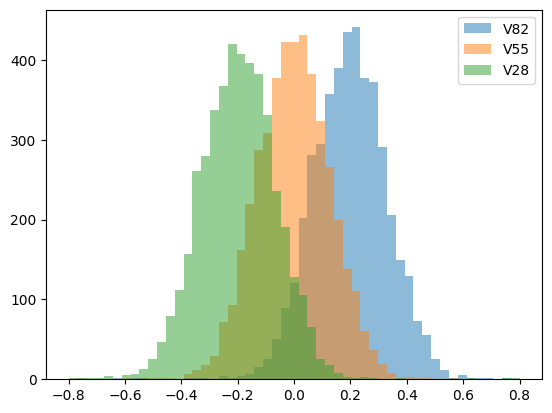

In [ ]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins = 51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_20) + np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_00) + np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_02) + np.mean(weighted_mean_00), bins = nbins, range = [-0.8,0.8], alpha = 0.5, label = 'V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28

print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))